<h1 align=center>  A/B Testing in Python

__In this notebok, we go through steps for conducting an A/B experiment using a dataset from Kaggle. We will follow these steps:__
>__1. Formulate Hypotheses__     
__2. Clean and Explore Data__     
__3. Design an Experiment__    
&emsp;&emsp; __a. Unit of Diversion__   
&emsp;&emsp; __b. Target Population__   
&emsp;&emsp; __c. Choose Sample Size__   
__4. Analyze Results__      
&emsp;&emsp; __a. Chi-Square Test__   
&emsp;&emsp; __b. Confidence Interval__  

The A/B Testing dataset from Kaggle has these columns:
- user_id
- timestamp
- group (control or  treatment)
- landing_page (old_page or new_page): this is the type of landing page users see depending on which experiment group they are in.
- converted (1-converted and 0-not converted): this is an indicator whether users converted (i.e., bought a product, subscribed to its services.) 

## Part 0. Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [2]:
df = pd.read_csv("~/Desktop/projects/AB_Testing/ab_data.csv")
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [3]:
df.shape

(294478, 5)

## Part 1. Formulate Hypotheses

We want to test if different landing page designs lead to different conversion rates of the users.

We will use __converted__ as our dependent variable. This is a binary indicator with the values: 
- 0: The user bought the product.
- 1: The user didn't buy the product.

#### Hypotheses

- Null hypothesis (H0): Customers seeing the new landing page have the same conversion rate as those who see the old landing page design.  
- Alternative hypothesis (Ha): Conversion rate for customers seeing the new landing page is different from that of customers seeing the old landing page. 

## Part 2. Clean and Explore Data

Before we move on, let's look at the dataset first.

In [4]:
# Check if users experienced only one version of landing page
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


There are some users who experienced both the old and new landing page. Luckily, they are fewer than 4000 users. Let's remove them from the data.

In [5]:
# Let's remove users who experienced both versions of landing page
version_counts = df['user_id'].value_counts()
drop_users = version_counts[version_counts > 1].index
df = df[~df['user_id'].isin(drop_users)]

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


In [6]:
# Check if the dataset is unique at the user level.
unique_users = df['user_id'].nunique() # number of user id's
row_count = df.shape[0] # number of rows

print(f'There are {row_count} records in the dataset.')
if unique_users == row_count:
    print('Dataset is unique by users.')
else:
    print('Dataset is not unique by users.')

There are 286690 records in the dataset.
Dataset is unique by users.


## Part 3. Design an Experiment

### A. Choose Unit of Diversion

We need to define what an individual subject is in the experiment. Three commonly used units of diversion are:
1. User ID: This is personally identifiable information for each user, i.e., login ID. So each userID experiences only one of the treatments.
2. Anonymous ID (cookie): This is unidentifiable but it can change when users switch browser or device. 
3. Event: Not a consistent experience for users. This is suitable for non-user-visible changes.    
     
Based on the goal of A/B testing, we need to choose appropriate units of diversion. We also need to have ethical consideration regarding user consent if experiment is userID-based and thus personally identifiable data is collected.

Following the choice of unit of diversion, we also need to consider unit of analysis. When the unit of analysis is different from the unit of diversion, the empricial variability of a metric can be much higher than the analytically computed variability.

In our example, our unit of diversion and unit of analysis would both be user ID.

### B. Choose Target Population

We need to decide who we are targeting for the experiment. If we don't want to expose too many users for a new feature that is being tested, then we might want to restrict the population. Or, if we think that certain features would have more impact on certain population group, then we would want to restrict our experiment for that group. This way, we can avoid diluting the effect of the experiment across a global population. However, we might know in advance which group will show effects from the experiment. 

### C. Choose Sample Size

In practice, we need to evaluate how many samples we need to have enough power to detect a significant effect. To calculate the required minimum sample size, we need the baseline estimate and expected effect size. Standard deviation is also required for continuouos outcome variable; but for our case, we have a binary outcome variable whose standard deviation can be easily computed analytically.  
Given that we don't have data prior to the AB testing, we will use the control group's conversion rate as our baseline rate, for the sake of our analysis.  

#### Baseline conversion rate

We are making an assumption that control group's conversion rate is the same as the conversion rate before the AB test.

In [7]:
baseline_rate = df['converted'][df['group']=='control'].mean()
print(f'Baseline conversion rate is {baseline_rate*100: .2f}%.')

Baseline conversion rate is  12.02%.


#### Effect size

Magnitude of difference in the conversion rates we expect to see between our treatment groups. Let's say that the expected change is about 1.5% (__ES = 0.015__). Sometimes, this value is the mangnitude of change the company wants to see, given the time and money invested in the change.  

#### Power

This is the probability of finding statistical significance between groups when a difference is actually present. __Power of 0.8__ is commonly used. We are also aiming for a 80% power.

#### Alpha 

This is the probability of rejecting the null hypothesis when there is no significant difference between groups. This is the critical value used for the test and we will be using a conventional __alpha value of 0.05__.

#### Sample size

Let's graph how sample sizes change with varying minimum detectable effect size, with alpha of 0.05 and power of 0.8. 

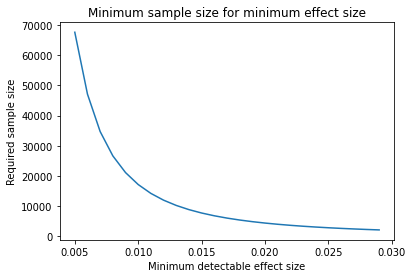

In [8]:
samplesize_list = []

deltas = np.arange(0.005, 0.03, 0.001)
for delta in deltas:
    new_rate = baseline_rate + delta
    effect_size = sms.proportion_effectsize(baseline_rate, new_rate)
    sample_size = sms.NormalIndPower().solve_power(effect_size=effect_size,
                                                   power=0.8,
                                                   alpha=0.05,
                                                   ratio=1)
    samplesize_list.append(sample_size)

plt.plot(deltas, samplesize_list)
plt.title('Minimum sample size for minimum effect size')
plt.ylabel('Required sample size')
plt.xlabel('Minimum detectable effect size')
plt.show()

This plot shows changes in sample sizes given different minimum effect sizes. 
For the test to detect an effect size as small as 0.5%, it needs at least 60,000 samples in each group.
On the other hand, for an effect size of 0.015, we need fewer than 10,000 samples.

In [9]:
# Let's calculate the sample size for our expected effect size of 0.015.
prob2 = baseline_rate + 0.015
effect_size = sms.proportion_effectsize(baseline_rate, prob2)
sample_size = ceil(sms.NormalIndPower().solve_power(effect_size=effect_size,power=0.8,alpha=0.05,ratio=1))
print(f'To detect an effect size of 0.015, we need at least {sample_size} samples in each group.')

To detect an effect size of 0.015, we need at least 7765 samples in each group.


In practice, we would have to think about how long we should run the test in order to reach the minimum sample size, considering daily traffic on company's website. 
Even if daily traffic is very large and we can reach the sample size within a few days, we would want to consider running the test for at least a week in order to capture both weekday and weekend trends. We might also consider assigning more traffic/users to control groups. 

In our dataset, we have more than 200,000 observations and the minimum sample size requirement is easily met.

## Part 4. Analyze the Results

### A. Chi-Square Test

Since our outcome variable is binary, it follows a bernoulli distribution. Therefore, we can use a chi-square test.    
A chi-square test is used when exploring relationship between two categorical variables.

In [10]:
# Organize data to run chi-square test
cont = df[df['group']=='control']
treat = df[df['group']=='treatment']

cont_conv = cont['converted'].sum()
cont_noconv = cont['converted'].shape[0] - cont_conv

treat_conv = treat['converted'].sum()
treat_noconv = treat['converted'].shape[0] - treat_conv

# Rearrange numbers into an array
T = np.array([[cont_conv, cont_noconv], [treat_conv, treat_noconv]])

In [11]:
# Run chi-square test
print(stats.chi2_contingency(T,correction=False)[1])

0.23228827305833816


The p-value of .23 is much bigger than our critical value of 0.05. This means that we fail to reject the null hypothesis and conclude that there is no significant difference in user conversion rates between the old and new landing page designs.

### B. Confidence Interval

Estimating 95% confidence interval is another way to evaluate the test. We are going to construct the confidence interval for our observed difference and see if the expected difference falls within the interval.

In [12]:
# Sample size - control
N_cont = cont.shape[0]
X_cont = cont_conv

# Sample size - treatment 
N_treat = treat.shape[0]
X_treat = treat_conv

# Difference in proportions
diff = X_treat/N_treat - X_cont/N_cont

# Pooled probability: total number of conversion / total number of users
pooled_prob = (X_cont + X_treat) / (N_cont + N_treat) 

# Pooled standard error
pooled_se = np.sqrt((pooled_prob)*(1-pooled_prob)*(1/N_cont + 1/N_treat))

# Margin of error
m = pooled_se * 1.96

# Get bounds for the confidence interval
lower_ci = diff - m
upper_ci = diff + m 

print(f'Difference in conversion rate between group is {diff:.4f}.')
print(f'The 95% interval is [{lower_ci:.4f}, {upper_ci:.4f}].')

Difference in conversion rate between group is -0.0014.
The 95% interval is [-0.0038, 0.0009].


The 95% confidence interval includes zero and the expected change of 0.015 is not included in the interval. Therefore, we fail to reject the null hypothesis and concludes that the different landing page designs don't have any statistically significant changes in customer conversion. 
This coincides with the chi-squared test results. 

## Conclusion

We've walked through important steps of designing and evaluating A/B testing on user conversion rates. Using both a chi-square test and constructing a 95% confidence interval, we have concluded that the old and new landing page don't affect the user conversion rates significantly. 